# Clustering Using HDBSCAN

### In this notebook, we perform the clustering of the professions using HDBSCAN.

### Import libraries

In [1]:
import os, sys, time
import pandas as pd, numpy as np
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import MDS, TSNE
import hdbscan
import pickle
import networkx as nx

%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

### Global variables

In [2]:
DATA = os.path.join('..', 'data')
RESULTS = os.path.join('..', 'results')

## Load the data

In [3]:
cosine_distances = pd.read_csv(os.path.join(RESULTS, 'cosine-distances.csv'), index_col=0)

print(f'Size of the data: {cosine_distances.shape}\n\n')
cosine_distances.head()

Size of the data: (183, 183)




,Accompagnant éducatif et social,Accompagnateur,Acheteur,Administration des ventes,Affrètement,Agent d'entretien,Agent d'exploitation,Agent de conditionnement,Agent de distribution,Agent de nettoyage,...,Tourneur / Fraiseur,Traducteur,Transaction immobilière,Transport de personnes,Trésorerie,Tuyauteur,Téléprospecteur,Veilleur de nuit,Vendeur,Éducateur de jeunes enfants
Accompagnant éducatif et social,0.000000,8.860117e-01,9.523340e-01,0.973784,0.948005,0.928518,0.954346,0.911404,0.905557,0.951443,...,0.957611,0.934752,0.970609,0.936311,0.972936,0.981805,0.926984,0.913953,0.866023,0.911643
Accompagnateur,0.886012,6.661338e-16,8.686821e-01,0.923574,0.846880,0.803823,0.868062,0.747200,0.717061,0.856915,...,0.890211,0.798719,0.913931,0.794872,0.899793,0.950402,0.771103,0.759349,0.559454,0.736694
Acheteur,0.952334,8.686821e-01,3.330669e-16,0.845253,0.883147,0.921188,0.851287,0.877307,0.855435,0.946180,...,0.948237,0.858679,0.931354,0.904318,0.901190,0.973375,0.835645,0.894690,0.813790,0.891210
Administration des ventes,0.973784,9.235735e-01,8.452527e-01,0.000000,0.933263,0.965769,0.916444,0.966269,0.907542,0.980894,...,0.986450,0.809096,0.944427,0.951543,0.898500,0.994200,0.837032,0.949449,0.909478,0.944884
Affrètement,0.948005,8.468802e-01,8.831468e-01,0.933263,0.000000,0.889186,0.654325,0.776134,0.808432,0.915348,...,0.907087,0.903338,0.965863,0.840880,0.952993,0.951299,0.885537,0.862841,0.836880,0.863905


# Step 1: Visualize the data

### Using Multidimensional scaling prjection (MDS)

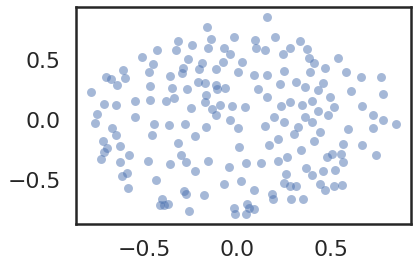

In [4]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=50)
mds_projection = mds.fit_transform(cosine_distances)
plt.scatter(*mds_projection.T, color='b', **plot_kwds)

Here, we can barely observe some very small clusters.

### Using T-distributed Stochastic Neighbor Embedding (TSNE)

/home/ariel/anaconda3/envs/gojob/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ariel/anaconda3/envs/gojob/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ariel/anaconda3/envs/gojob/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


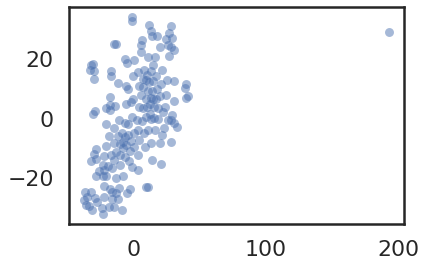

In [5]:
tsne = TSNE(n_components=2, metric='precomputed',random_state=50)
tsne_projection = tsne.fit_transform(cosine_distances)
plt.scatter(*tsne_projection.T, color='b', **plot_kwds)

TSNE being a stochastic method, several runs could be necessary to obtain an apropriate result (visualization).

Unlike with MSD, here, we can observe some clearer cluster structures within the data.

Let's explore this clusters in the following part.

# Step 2: Cluster the data

In [6]:
%%time
# epsilon = math.cos(math.pi/4) # angle = pi / 12 = 15 degrees below which we consider to group professions

clusterer = hdbscan.HDBSCAN(min_cluster_size=2,
                            min_samples=1,
                            cluster_selection_method='eom',
                            # cluster_selection_epsilon=epsilon,
                            prediction_data=True,
                            gen_min_span_tree=True,
                            metric='precomputed')
clusterer.fit(cosine_distances)

CPU times: user 548 ms, sys: 7.75 ms, total: 555 ms
Wall time: 38.1 ms


/home/ariel/anaconda3/envs/gojob/lib/python3.9/site-packages/hdbscan/hdbscan_.py:967: UserWarning: Cannot generate prediction data for non-vectorspace inputs -- access to the source data ratherthan mere distances is required!
  warn('Cannot generate prediction data for non-vector'


HDBSCAN(gen_min_span_tree=True, metric='precomputed', min_cluster_size=2,
        min_samples=1, prediction_data=True)

### We can see the different clusters ids

In [7]:
np.unique(clusterer.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

# Step 3: Build and visualize the cluster hierarchy

<AxesSubplot:ylabel='distance'>

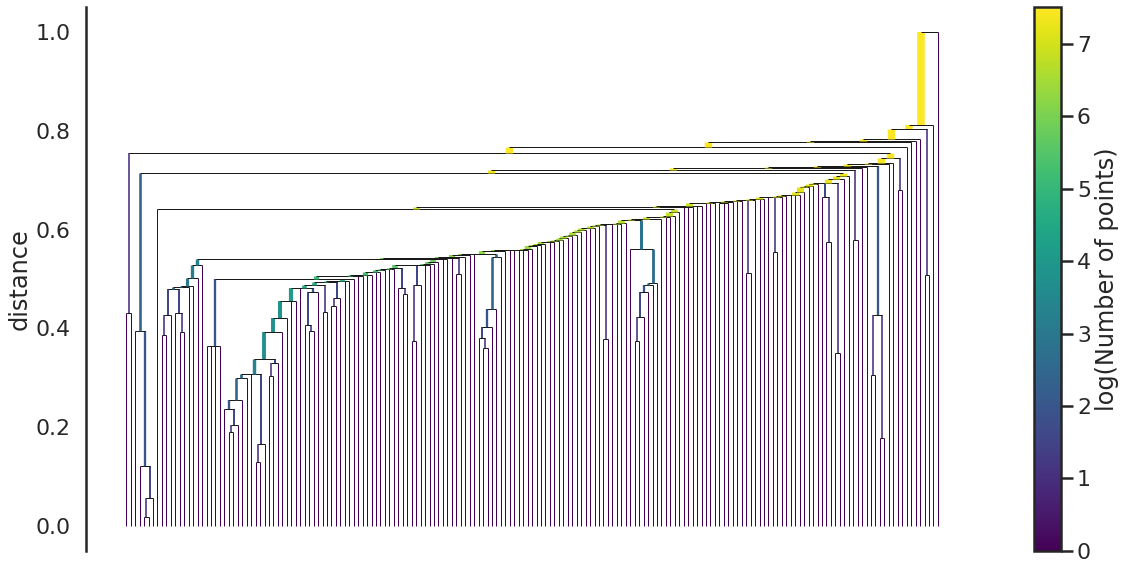

In [8]:
plt.figure(figsize=(20, 10))
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

# Step 4: Condense and visaualize the cluster tree

<AxesSubplot:ylabel='$\\lambda$ value'>

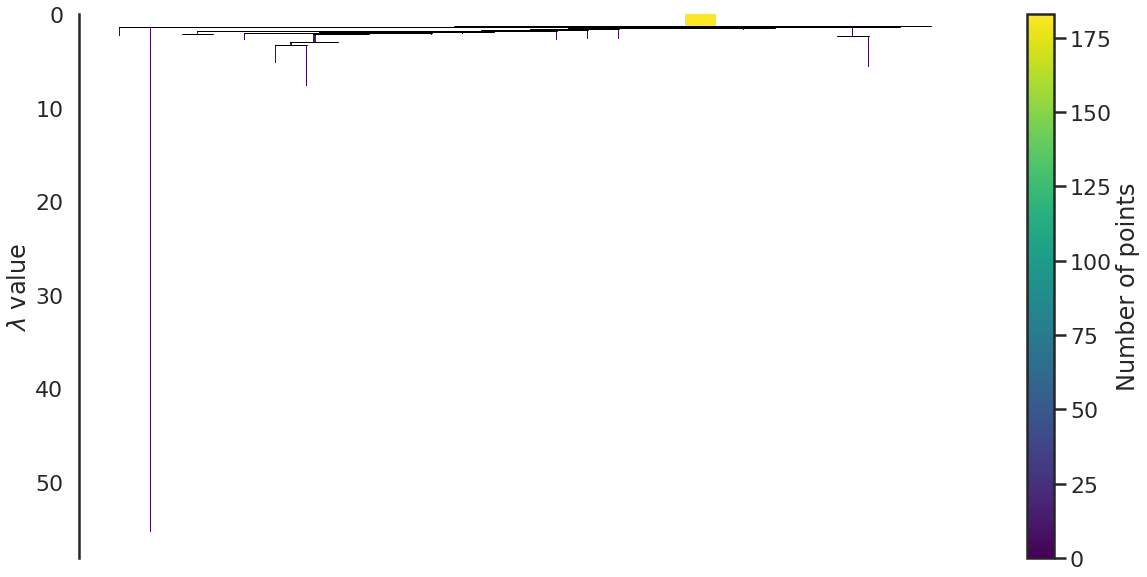

In [9]:
plt.figure(figsize=(20, 10))
clusterer.condensed_tree_.plot()

# Step 5: Extract and visualize the clusters

<AxesSubplot:ylabel='$\\lambda$ value'>

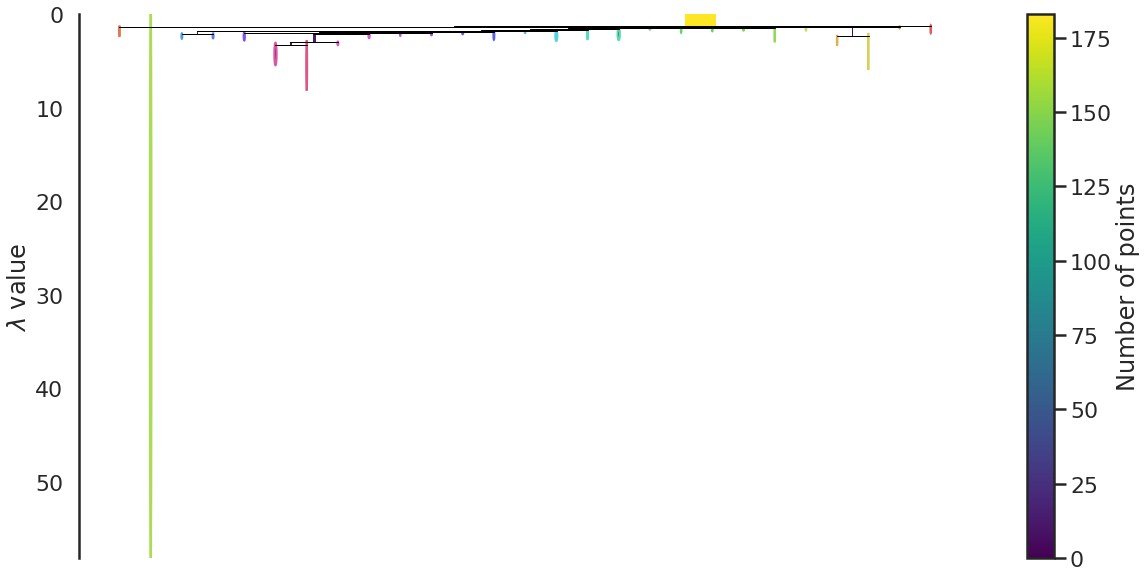

In [10]:
plt.figure(figsize=(20, 10))
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette("hls", len(np.unique(clusterer.labels_))))

### Using Multidimensional scaling prjection (MDS)

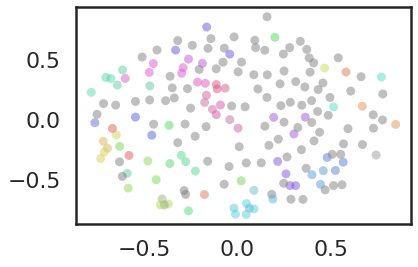

In [11]:
palette = sns.color_palette("hls", len(np.unique(clusterer.labels_)))
cluster_colors = [sns.desaturate(palette[col], sat) if col >= 0 else (0.5, 0.5, 0.5) for col, sat in zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(*mds_projection.T, c=cluster_colors, **plot_kwds)

### Using T-distributed Stochastic Neighbor Embedding (TSNE)

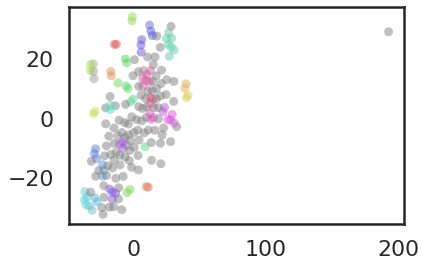

In [12]:
cluster_colors = [sns.desaturate(palette[col], sat) if col >= 0 else (0.5, 0.5, 0.5) for col, sat in zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(*tsne_projection.T, c=cluster_colors, **plot_kwds)

**With both visualizations, we can observe the created clusters in colors.**

**The clusters are of various size, but are all very small.**

**Most of the professions are not clustered.**

# Step 6: Get clusters representative

Here, we extract the clusters most representative professsions.

Indeed, HDBSCAN uses soft clustering, so some points are associated with the clusters with more or less strengths.

So, we just extract the examplars points of the clusters, that are in fact, the ones at their heart. They are the points associated with the clusters with higher strength.

Consequently, these examplars points represent the professions with stronger association.

In [13]:
def get_clusters_professions(clusterer, profession_list):
    """ 
    Get all the associated documents per topic.
    
    Arguments:
        clusterer: the hdbscan clusterer model
        profession_list: the list of the professions
    """
    
    labels = clusterer.labels_
    professions_per_cluster = {}
    
    for cluster in list(np.unique(clusterer.labels_)):
        if cluster != -1:
            # get the professions ids
            pos = np.where(np.array(labels) == cluster)[0].tolist()
            professions_accessed_array = np.array(profession_list)[pos]
            professions_per_cluster[cluster] = list(professions_accessed_array)
            
    professions_per_cluster = pd.DataFrame(professions_per_cluster.items(), columns=['cluster', 'professions'])
    professions_per_cluster['size'] = professions_per_cluster['professions'].apply(lambda x: len(x))
    professions_per_cluster = professions_per_cluster.sort_values('size', ascending=False)
    professions_per_cluster = professions_per_cluster[professions_per_cluster['size'] > 1]
    professions_per_cluster = professions_per_cluster.reset_index(drop=True)
            
    return professions_per_cluster


def get_representative(clusterer, profession_list):
    """ 
    Get the most representative professions per topic
    The most representative docs are extracted by taking
    the exemplars from the HDBSCAN-generated clusters.
    
    Full instructions can be found here:
        https://hdbscan.readthedocs.io/en/latest/soft_clustering_explanation.html
        
    Arguments:
        clusterer: the hdbscan clusterer model
        profession_list: the list of the professions
    """
    
    # Prepare the condensed tree and luf clusters beneath a given cluster
    condensed_tree = clusterer.condensed_tree_
    raw_tree = condensed_tree._raw_tree
    clusters = sorted(condensed_tree._select_clusters())
    cluster_tree = raw_tree[raw_tree['child_size'] > 1]
    #  Find the points with maximum lambda value in each leaf
    representative_docs = {}
    for cluster in list(np.unique(clusterer.labels_)):
        if cluster != -1:
            leaves = hdbscan.plots._recurse_leaf_dfs(cluster_tree, clusters[cluster])
            result = np.array([])
            for leaf in leaves:
                max_lambda = raw_tree['lambda_val'][raw_tree['parent'] == leaf].max()
                points = raw_tree['child'][(raw_tree['parent'] == leaf) & (raw_tree['lambda_val'] == max_lambda)]
                result = np.hstack((result, points))
            representative_docs[cluster] = result.astype(int)
    # Convert indices to professions
    representative_professions_per_cluster = {cluster: [profession_list[doc_id] for doc_id in doc_ids]
                      for cluster, doc_ids in representative_docs.items()}
    
    representative_professions_per_cluster = pd.DataFrame(representative_professions_per_cluster.items(), columns=['cluster', 'professions'])
    representative_professions_per_cluster['size'] = representative_professions_per_cluster['professions'].apply(lambda x: len(x))
    representative_professions_per_cluster = representative_professions_per_cluster.sort_values('size', ascending=False)
    representative_professions_per_cluster = representative_professions_per_cluster[representative_professions_per_cluster['size'] > 1]
    representative_professions_per_cluster = representative_professions_per_cluster.reset_index(drop=True)
    
    return representative_professions_per_cluster

In [14]:
profession_list = list(cosine_distances.columns)
professions_per_cluster = get_clusters_professions(clusterer, profession_list)
representative_professions_per_cluster = get_representative(clusterer, profession_list)

In [15]:
professions_per_cluster

,cluster,professions,size
0,25,"[Chauffeur VL, Déménageur, Hotliner, Manoeuvre...",7
1,12,"[Chef d'atelier, Electromécanicien, Electronic...",7
2,14,"[Auditeur comptable, Comptable clients, Compta...",6
3,6,"[Infirmier, Infirmier anesthésiste, Infirmier ...",5
4,23,"[Jardinier, Maçon, Nacelliste, Paysagiste]",4
5,20,"[Chargé d'affaires, Chargé de clientèle, Comme...",4
6,26,"[Agent de conditionnement, Manutentionnaire, P...",3
7,16,"[Assistant de direction, Assistant polyvalent ...",3
8,24,"[Cariste, Magasinier, Réceptionnaire]",3
9,21,"[Animateur de ventes / Promotion, Artistique, ...",3


In [16]:
representative_professions_per_cluster

,cluster,professions,size
0,0,"[Ouvrier Technicien, Technicien de laboratoire]",2
1,14,"[Comptable clients, Comptable fournisseurs]",2
2,25,"[Déménageur, Postier]",2
3,24,"[Réceptionnaire, Magasinier]",2
4,23,"[Jardinier, Maçon]",2
5,22,"[Charpentier, Plaquiste]",2
6,21,"[Vendeur, Artistique]",2
7,20,"[Chargé d'affaires, Chargé de clientèle]",2
8,19,"[Radiologue, Electricien]",2
9,18,"[Opérateur commandes numériques, Soudeur]",2


### Graph containing the single nodes

#### We can use the graph structure generated by HDBSCAN with associated weights to use graph clustering later.

In [17]:
clusters_df = clusterer.condensed_tree_.to_pandas()
clusters_df = clusters_df[clusters_df['child_size'] == 1].sort_values('lambda_val', ascending=False)
clusters_df.columns = ['parent', 'child', 'weight', 'size']
clusters_df = clusters_df[clusters_df.columns[:-1]]
clusters_df = clusters_df.reset_index(drop=True)
clusters_df

,parent,child,weight
0,196,105,55.373040
1,196,107,55.373040
2,196,104,17.695988
3,196,106,8.238275
4,235,119,7.719186
...,...,...,...
178,184,175,1.285459
179,184,48,1.283300
180,184,99,1.276356
181,183,24,1.232206


### NetworkX graph

In [18]:
G = nx.from_pandas_edgelist(clusters_df, source='parent', target='child', edge_attr='weight')
G.number_of_nodes()

228

## Save the results

In [19]:
professions_per_cluster.to_csv(os.path.join(RESULTS, 'hdbscan-professions-per-cluster.csv'), index=False)
representative_professions_per_cluster.to_csv(os.path.join(RESULTS, 'hdbscan-representative-professions-per-cluster.csv'), index=False)